<a href="https://colab.research.google.com/github/Mikoy2323/Maternal-health-risk-analysis/blob/main/Maternal_health_risk_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries

In [185]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns
import tensorflow as tf
from tabulate import tabulate

#Data preprocessing and initial distribution analysis

Risk Level labels: ['high risk' 'low risk' 'mid risk']
0 null values




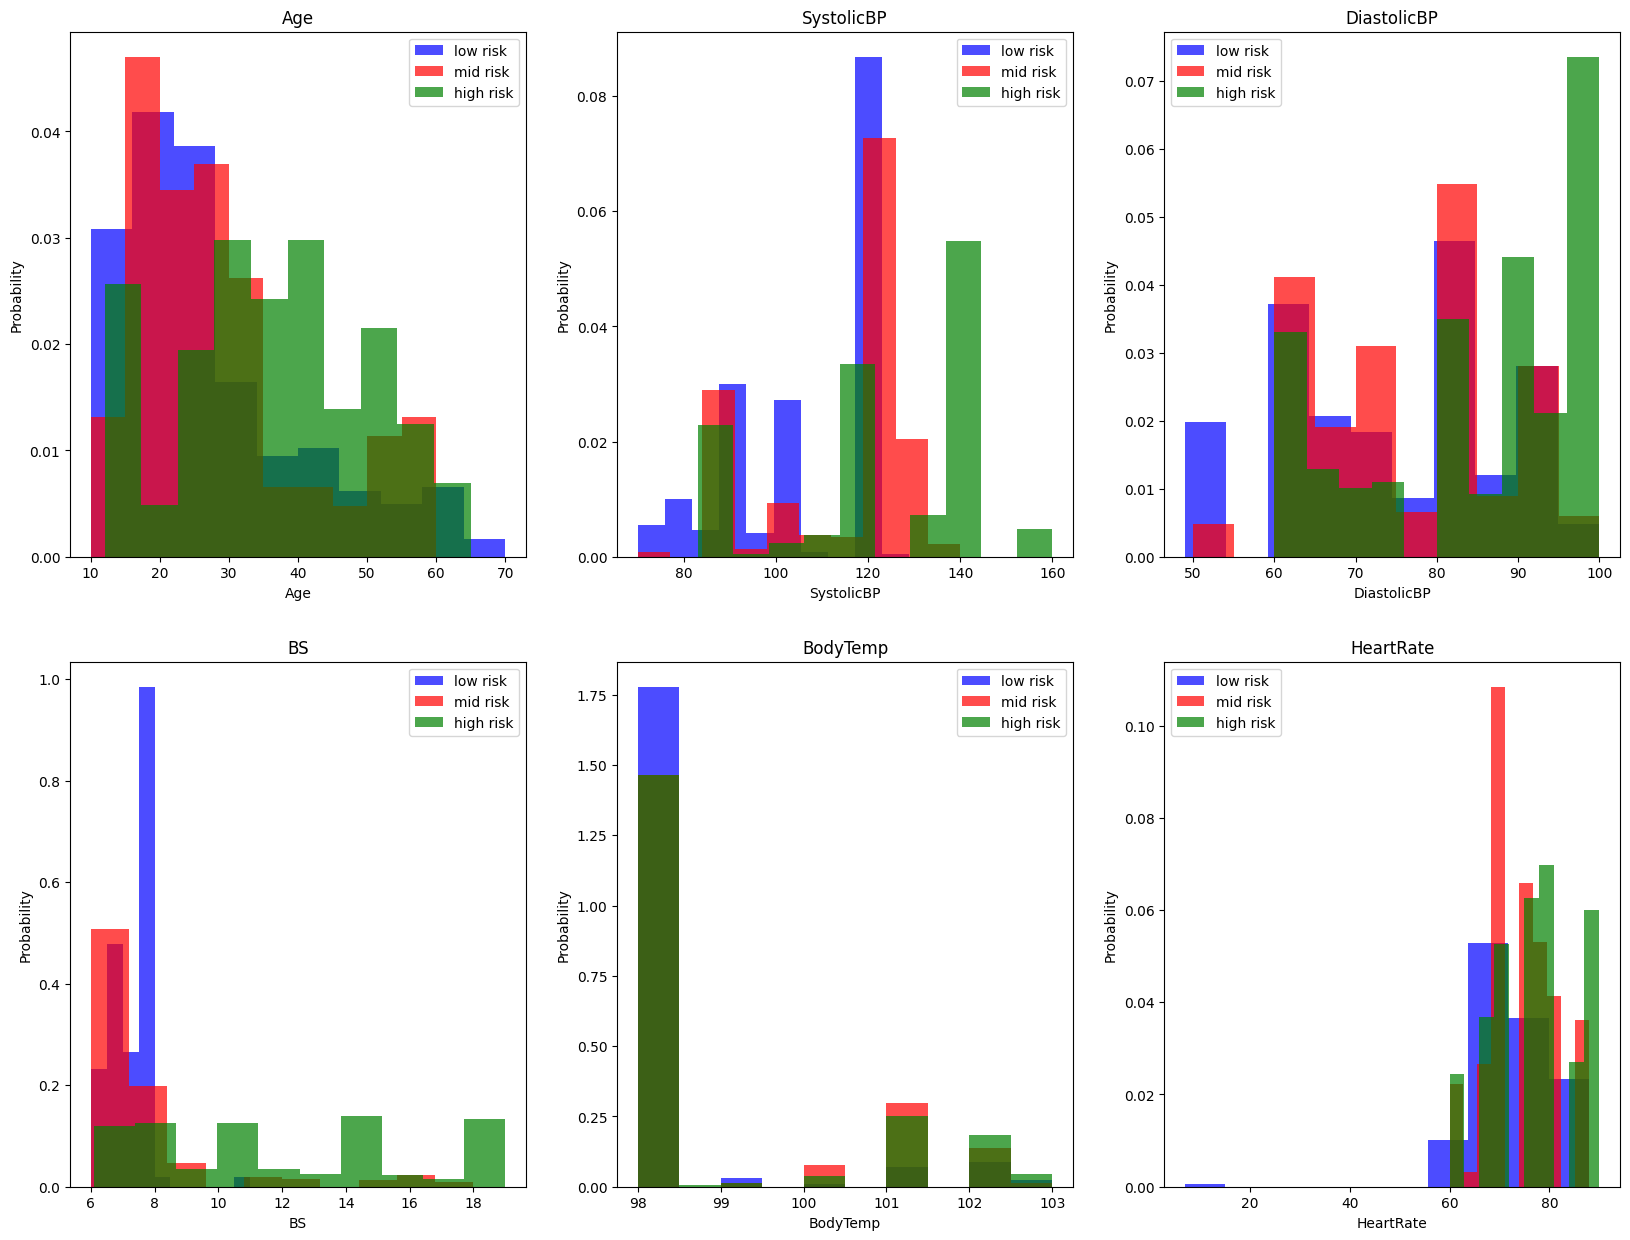

In [186]:

df=pd.read_csv('Maternal Health Risk Data Set.csv')
print(f"Risk Level labels: {df.RiskLevel.unique()}")
df.replace(["low risk","mid risk","high risk"],[0,1,2],inplace=True)
print(f"{df.isna().sum().sum()} null values\n\n")


fig,ax=plt.subplots(2,3,figsize=(20,15))
nrow=0
ncol=0

for col in df.columns[:-1]:
  ax[ncol,nrow].hist(df[df["RiskLevel"]==0][col],density=True,alpha=0.7,color="blue",label="low risk")
  ax[ncol,nrow].hist(df[df["RiskLevel"]==1][col],density=True,alpha=0.7,color="red",label="mid risk")
  ax[ncol,nrow].hist(df[df["RiskLevel"]==2][col],density=True,alpha=0.7,color="green",label="high risk")
  ax[ncol,nrow].set_title(col)
  ax[ncol,nrow].set_xlabel(col)
  ax[ncol,nrow].set_ylabel("Probability")
  ax[ncol,nrow].legend()
  nrow+=1
  if nrow>2:
    nrow=0
    ncol+=1
plt.show()




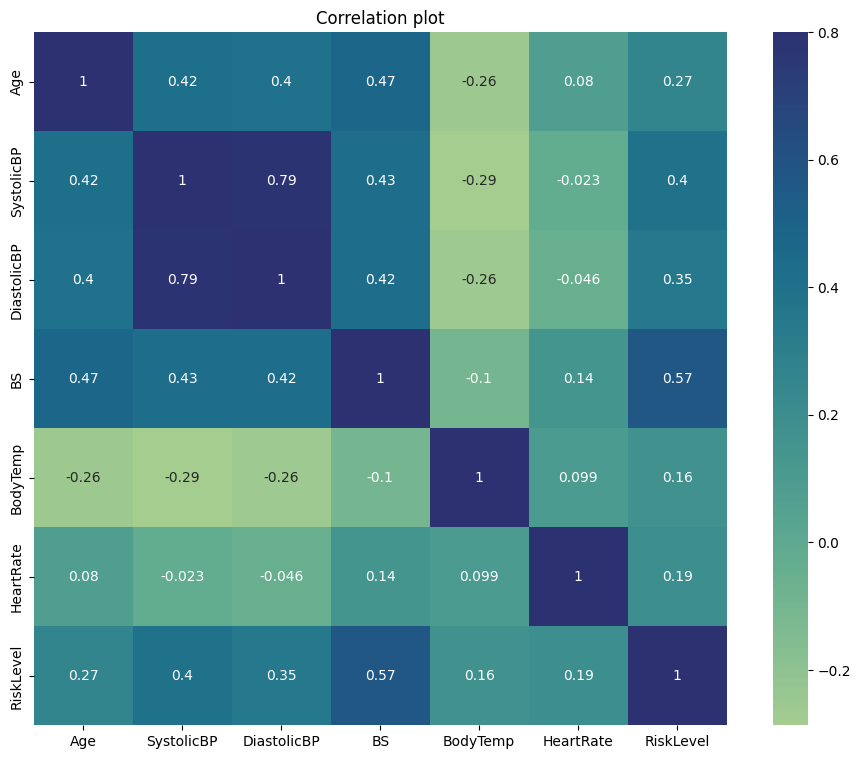

In [187]:
correlation_matrix = df.corr()
fig = plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix,vmax=0.8,square = True,cmap="crest",annot=True)
plt.title("Correlation plot")
plt.show()

#Further preprocessing and outliers detection

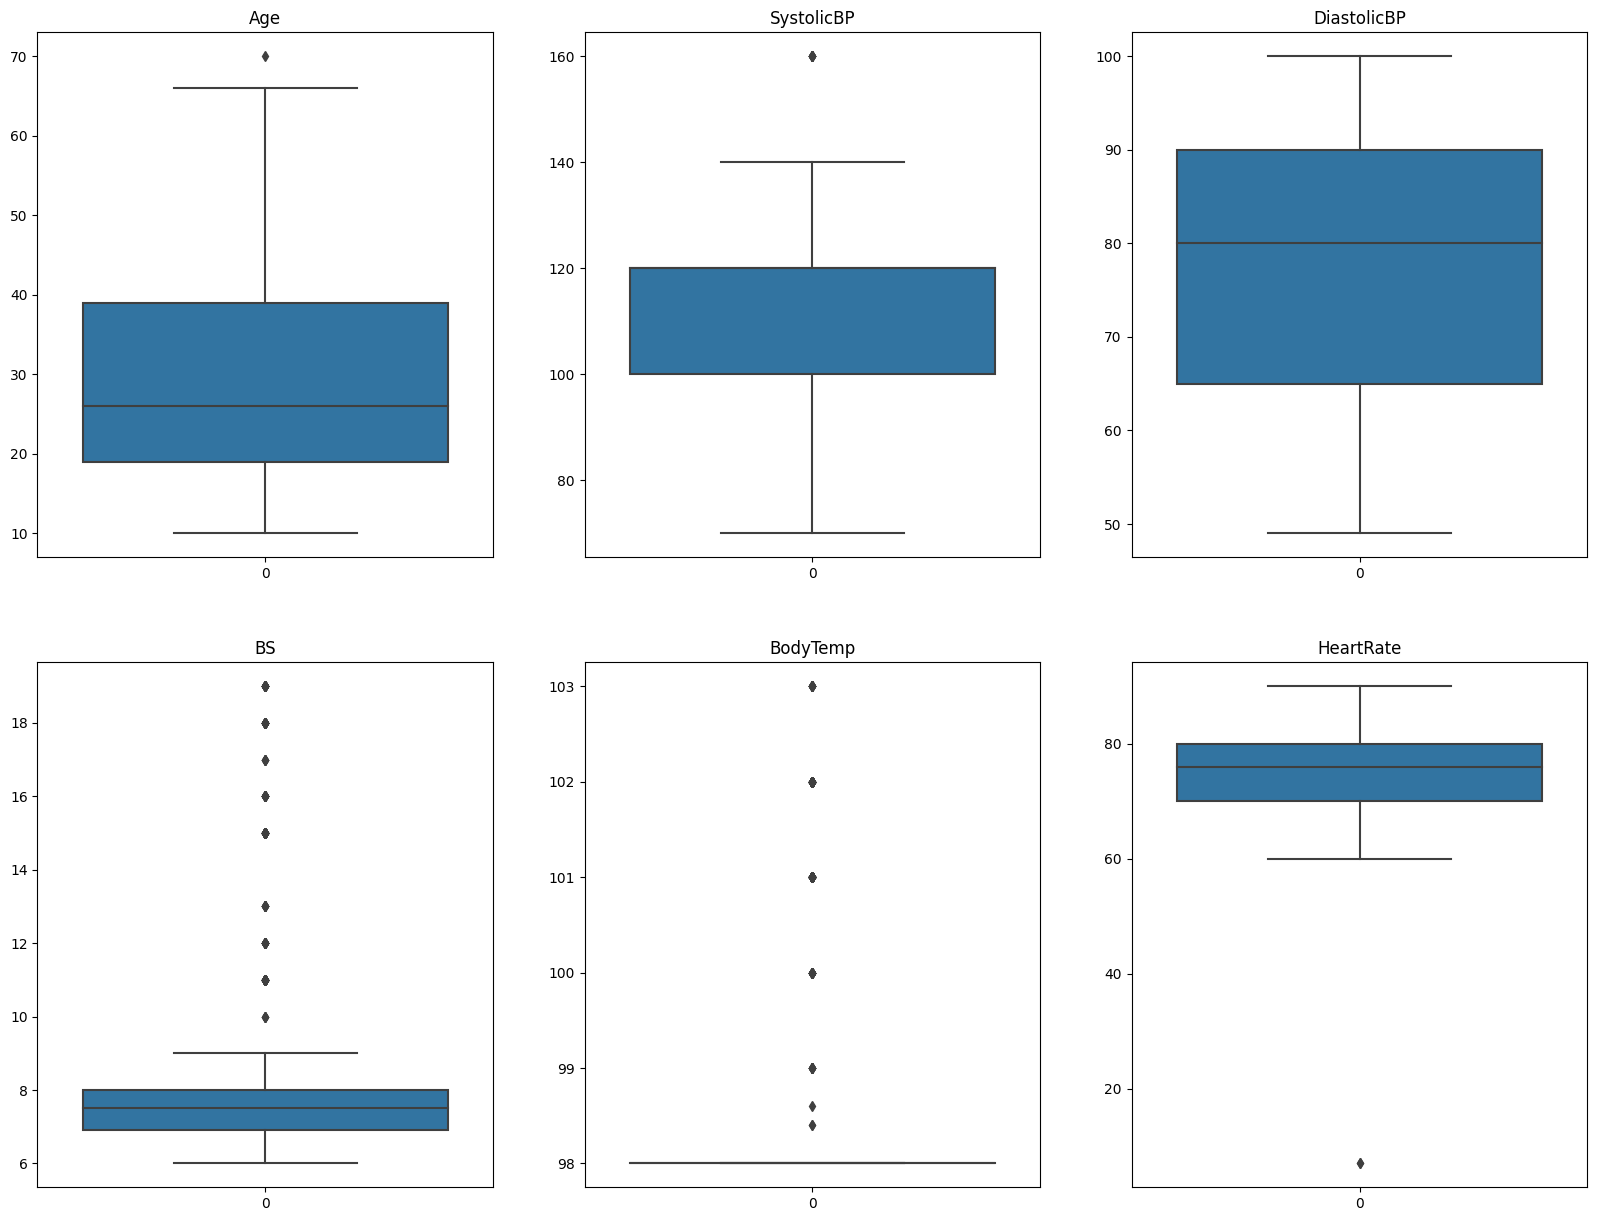

In [188]:
fig,ax=plt.subplots(2,3,figsize=(20,15))
nrow=0
ncol=0
for col in df.columns[:-1]:
  sns.boxplot(df[col],ax=ax[ncol,nrow])
  ax[ncol,nrow].set_title(col)
  nrow+=1
  if nrow>2:
    nrow=0
    ncol+=1
plt.show()





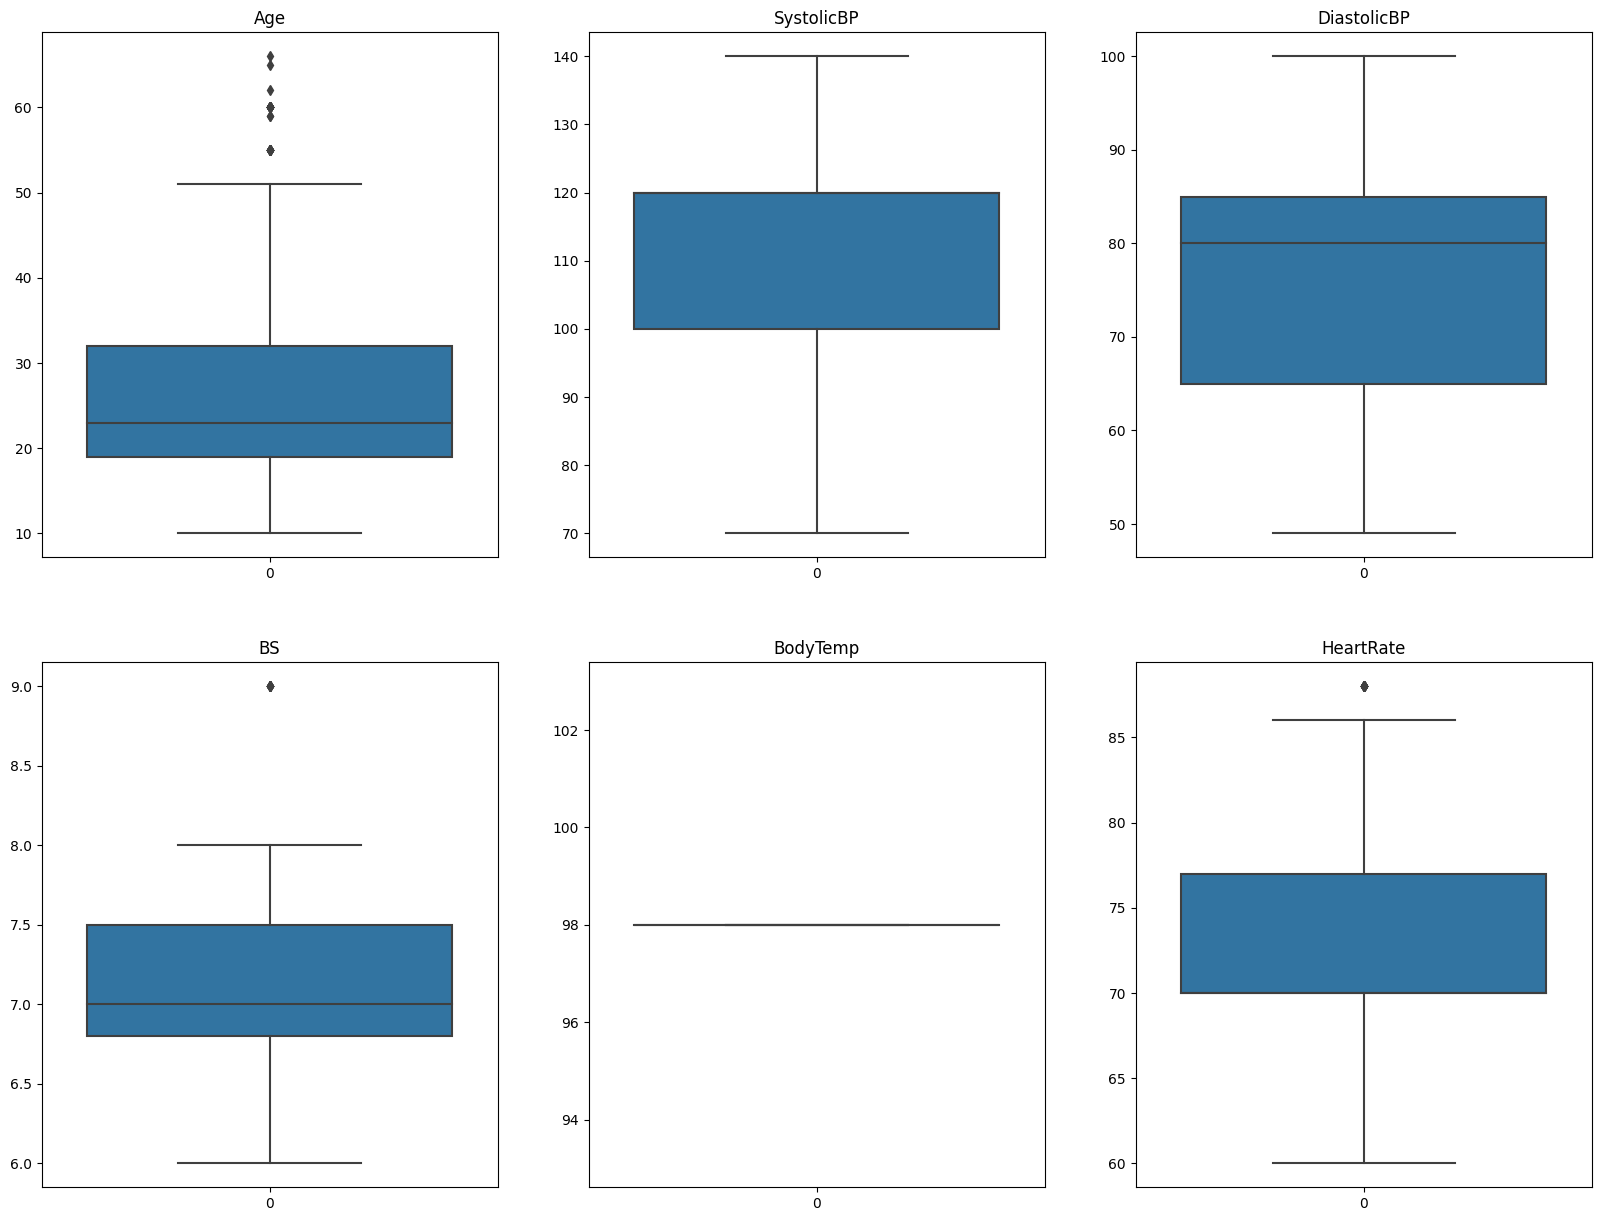

In [189]:

idx=df["HeartRate"].sort_values().head(2).index
df.drop(index=idx,inplace=True)

Q1=df.quantile(0.25)
Q3=df.quantile(0.75)
IQR=Q3-Q1

threshold=1.5
outlier_rows = ((df < (Q1 - threshold * IQR)) | (df > (Q3 + threshold * IQR))).any(axis=1)
df=df[~outlier_rows]

df.reset_index(drop=True,inplace=True)
fig,ax=plt.subplots(2,3,figsize=(20,15))
nrow=0
ncol=0

for col in df.columns[:-1]:
  sns.boxplot(df[col],ax=ax[ncol,nrow])
  ax[ncol,nrow].set_title(col)
  nrow+=1
  if nrow>2:
    nrow=0
    ncol+=1
plt.show()


#Equalizing number of rows for each class

In [190]:
print("before sampling\n",len(df[df["RiskLevel"]==0]))
print(len(df[df["RiskLevel"]==1]))
print(len(df[df["RiskLevel"]==2]),"\n")

from imblearn.over_sampling import RandomOverSampler
df.drop("BodyTemp",axis=1,inplace=True)
cols=df.columns
X=df.drop('RiskLevel',axis=1)
Y=df['RiskLevel']
ros=RandomOverSampler(random_state=1)
X,Y=ros.fit_resample(X,Y)


print("after resampling\n",sum(Y==0))
print(sum(Y==1))
print(sum(Y==2))

data=np.hstack((X,np.reshape(Y.values,(-1,1))))



before sampling
 353
216
51 

after resampling
 353
353
353


#Spliting data

In [191]:
from sklearn.model_selection import train_test_split
df=pd.DataFrame(data,columns=cols)
X=df.drop('RiskLevel',axis=1)
Y=df['RiskLevel'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1, shuffle=True)


#Scaling data

In [192]:

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_normal = scaler.fit_transform(X_train)
X_train_normal = pd.DataFrame(X_train_normal, columns=X.columns)

X_test_normal = scaler.fit_transform(X_test)
X_test_normal = pd.DataFrame(X_test_normal, columns=X.columns)


#Result comparasion function

In [193]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from IPython.display import display, HTML

cols=pd.MultiIndex.from_product([["precision","recall","f1"],["0","1","2","macro avg","weighted avg"]])
comp_df=pd.DataFrame(np.zeros([1,15]),columns=cols)
comp_df.insert(0,"accuracy",0.0)
comp_df.insert(0,"Name",None)


def add_to_comparasion(name,y_pred):
  arr=[name,accuracy_score(y_test,y_pred),
       precision_score(y_test,y_pred,average=None),  precision_score(y_test,y_pred,average="macro"),  precision_score(y_test,y_pred,average="weighted"), 
       recall_score(y_test,y_pred,average=None),     recall_score(y_test,y_pred,average="macro"),     recall_score(y_test,y_pred,average="weighted"),
       f1_score(y_test,y_pred,average=None),         f1_score(y_test,y_pred,average="weighted"),      f1_score(y_test,y_pred,average="macro")]

  for i in range(len(arr)+3):
    if type(arr[i])==np.ndarray:
        arr[i:i+1]=arr[i]

  
  if comp_df.Name.values[0] is None: 
    comp_df.loc[len(comp_df)-1]=arr 
  else: comp_df.loc[len(comp_df)]=arr
  comp_df.sort_values(by="accuracy",inplace=True,ascending=False)
  comp_df.reset_index(drop=True,inplace=True)
  display(HTML(comp_df.to_html()))





# SVM

In [194]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
svm_model=SVC()
svm_model=svm_model.fit(X_train_normal,y_train)
y_pred=svm_model.predict(X_test_normal)
print(classification_report(y_test,y_pred))
add_to_comparasion("SVM",y_pred)


              precision    recall  f1-score   support

           0       0.64      0.78      0.70        69
           1       0.76      0.74      0.75        72
           2       1.00      0.80      0.89        71

    accuracy                           0.77       212
   macro avg       0.80      0.77      0.78       212
weighted avg       0.80      0.77      0.78       212



In [195]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
svm=SVC()
params={"C":[0.1,1,3,5,7,10,30,100],"kernel":["linear","poly","rbf"],'gamma': [0.1, 0.01, 0.001,'scale']}
cv = KFold(n_splits=10, shuffle=True)
gs_svm = GridSearchCV(svm, params,scoring='accuracy', cv=cv)
gs_svm.fit(X_train_normal, y_train)
y_pred=gs_svm.predict(X_test_normal)
print(classification_report(y_test,y_pred))
add_to_comparasion("SVM gs",y_pred)

              precision    recall  f1-score   support

           0       0.79      0.83      0.81        69
           1       0.84      0.85      0.84        72
           2       1.00      0.94      0.97        71

    accuracy                           0.87       212
   macro avg       0.88      0.87      0.87       212
weighted avg       0.88      0.87      0.87       212



#Naive Bayes

In [196]:
from sklearn.naive_bayes import GaussianNB
gnb_model = GaussianNB()
gnb_model = gnb_model.fit(X_train_normal, y_train)
y_pred=gnb_model.predict(X_test_normal)
print(classification_report(y_test,y_pred))
add_to_comparasion("Bayes",y_pred)



              precision    recall  f1-score   support

           0       0.58      0.45      0.51        69
           1       0.58      0.65      0.61        72
           2       0.72      0.79      0.75        71

    accuracy                           0.63       212
   macro avg       0.63      0.63      0.62       212
weighted avg       0.63      0.63      0.63       212



In [197]:
params = {'var_smoothing': np.logspace(0,-9, num=100)}
cv = KFold(n_splits=10, shuffle=True)
gnb_model = GaussianNB()
gs_nb = GridSearchCV(gnb_model, params, scoring='accuracy', cv=cv)
gs_nb.fit(X_train_normal, y_train)
y_pred=gs_nb.predict(X_test_normal)
print(classification_report(y_test,y_pred))
add_to_comparasion("Bayes gs",y_pred)

              precision    recall  f1-score   support

           0       0.60      0.43      0.50        69
           1       0.57      0.65      0.61        72
           2       0.71      0.79      0.75        71

    accuracy                           0.63       212
   macro avg       0.63      0.63      0.62       212
weighted avg       0.63      0.63      0.62       212



#KNN

In [198]:
from sklearn.neighbors import KNeighborsClassifier
knn_model=KNeighborsClassifier()
knn_model=knn_model.fit(X_train_normal,y_train)
y_pred=knn_model.predict(X_test_normal)
print(classification_report(y_test,y_pred))
add_to_comparasion("KNN",y_pred)

              precision    recall  f1-score   support

           0       0.79      0.78      0.79        69
           1       0.76      0.81      0.78        72
           2       0.99      0.94      0.96        71

    accuracy                           0.84       212
   macro avg       0.85      0.84      0.85       212
weighted avg       0.85      0.84      0.85       212



In [199]:

params={"n_neighbors":[1,3,5,7,9],'weights': ['uniform', 'distance'],'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size': [10, 30, 50]}

cv = KFold(n_splits=10, shuffle=True)

knn=KNeighborsClassifier()
gs_knn = GridSearchCV(knn, params, scoring='accuracy', cv=cv)
gs_knn.fit(X_train_normal, y_train)

y_pred=gs_knn.predict(X_test_normal)
print(classification_report(y_test,y_pred))
add_to_comparasion("KNN gs",y_pred)

              precision    recall  f1-score   support

           0       0.84      0.78      0.81        69
           1       0.82      0.86      0.84        72
           2       0.99      1.00      0.99        71

    accuracy                           0.88       212
   macro avg       0.88      0.88      0.88       212
weighted avg       0.88      0.88      0.88       212



#Decision Tree

In [200]:
from sklearn.tree import DecisionTreeClassifier
#this model performs better for not scaled data
dtc_model=DecisionTreeClassifier()
dtc_model=dtc_model.fit(X_train,y_train)
y_pred=dtc_model.predict(X_test)
print(classification_report(y_test,y_pred))
add_to_comparasion("Decision Tree",y_pred)

              precision    recall  f1-score   support

           0       0.90      0.88      0.89        69
           1       0.90      0.90      0.90        72
           2       0.99      1.00      0.99        71

    accuracy                           0.93       212
   macro avg       0.93      0.93      0.93       212
weighted avg       0.93      0.93      0.93       212



In [201]:
params = {'criterion': ['entropy', 'gini'],'max_depth': [None, 3, 5, 7, 9],'min_samples_split': [2,3, 5, 7,9],'min_samples_leaf': [1, 2, 3],
              'max_features': ['sqrt', 'log2', None]
}
dtc=DecisionTreeClassifier()
cv = KFold(n_splits=10, shuffle=True)
gs_dtc = GridSearchCV(dtc, params, scoring='accuracy', cv=cv)
gs_dtc.fit(X_train, y_train)

y_pred=gs_dtc.predict(X_test)
print(classification_report(y_test,y_pred))
add_to_comparasion("Decision Tree gs",y_pred)


              precision    recall  f1-score   support

           0       0.90      0.88      0.89        69
           1       0.89      0.90      0.90        72
           2       1.00      1.00      1.00        71

    accuracy                           0.93       212
   macro avg       0.93      0.93      0.93       212
weighted avg       0.93      0.93      0.93       212



#Random Forest

In [202]:
from sklearn.ensemble import RandomForestClassifier

#model responded better to not scaled data
rfc_model=RandomForestClassifier()
rfc_model = rfc_model.fit(X_train,y_train)
y_pred=rfc_model.predict(X_test)
print(classification_report(y_test,y_pred))
add_to_comparasion("Random Forest ",y_pred)


              precision    recall  f1-score   support

           0       0.91      0.88      0.90        69
           1       0.92      0.92      0.92        72
           2       0.97      1.00      0.99        71

    accuracy                           0.93       212
   macro avg       0.93      0.93      0.93       212
weighted avg       0.93      0.93      0.93       212



In [203]:
params = {'n_estimators': [100],'criterion': ['gini', 'entropy'],'max_depth': [None, 3, 5, 10],'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': ['sqrt', 'log2', None]
}
rfc_model=RandomForestClassifier()
gs_rfc = GridSearchCV(rfc_model, params, scoring='accuracy', cv=5)
gs_rfc.fit(X_train,y_train)
y_pred=gs_rfc.predict(X_test)
print(classification_report(y_test,y_pred))
add_to_comparasion("Random Forest gs",y_pred)


              precision    recall  f1-score   support

           0       0.88      0.87      0.88        69
           1       0.89      0.89      0.89        72
           2       0.99      1.00      0.99        71

    accuracy                           0.92       212
   macro avg       0.92      0.92      0.92       212
weighted avg       0.92      0.92      0.92       212



#Gradient Boosting

In [204]:
from sklearn.ensemble import GradientBoostingClassifier
#this model also performing better for not scaled data
gbc_model=GradientBoostingClassifier()
gbc_model=gbc_model.fit(X_train,y_train)
y_pred=gbc_model.predict(X_test)
print(classification_report(y_test,y_pred))
add_to_comparasion("Gradient Boosting",y_pred)

              precision    recall  f1-score   support

           0       0.83      0.78      0.81        69
           1       0.81      0.85      0.83        72
           2       0.99      1.00      0.99        71

    accuracy                           0.88       212
   macro avg       0.88      0.88      0.88       212
weighted avg       0.88      0.88      0.88       212



In [205]:
params = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
}
gbc_model=GradientBoostingClassifier()
gs_gbc = GridSearchCV(gbc_model, params, scoring='accuracy', cv=5)
gs_gbc.fit(X_train,y_train)
y_pred=gs_gbc.predict(X_test)
print(classification_report(y_test,y_pred))
add_to_comparasion("Gradient Boosting gs",y_pred)

              precision    recall  f1-score   support

           0       0.88      0.84      0.86        69
           1       0.85      0.89      0.87        72
           2       1.00      1.00      1.00        71

    accuracy                           0.91       212
   macro avg       0.91      0.91      0.91       212
weighted avg       0.91      0.91      0.91       212



#Neural Network Classifier


##Defining functions form ploting loss and accuracy

In [206]:
def plot_loss(history):
  plt.plot(history.history['loss'],label='loss')
  plt.plot(history.history['val_loss'],label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('categorical crossentropy')
  plt.legend()
  plt.grid(True)
  plt.show()

def plot_accuracy(history):
  plt.plot(history.history['accuracy'],label='accuracy')
  plt.plot(history.history['val_accuracy'],label='val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)
  plt.show()

In [207]:
def train_model(X_train,y_train,num_nodes,lr,batch_size,epochs):
    nn_model=tf.keras.Sequential([
      tf.keras.layers.Dense(num_nodes,activation='relu',input_shape=(5,)),
      tf.keras.layers.Dense(num_nodes,activation='relu'),
      tf.keras.layers.Dense(3,activation='softmax'),                         
  ])
    nn_model.compile(optimizer=tf.keras.optimizers.Adam(lr),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    history=nn_model.fit(X_train_normal,y_train,epochs=epochs,batch_size=batch_size,validation_split=0.2,verbose=0)
    return nn_model,history 

In [208]:
nn_model,history=train_model(X_train,y_train,32,0.001,32,200)


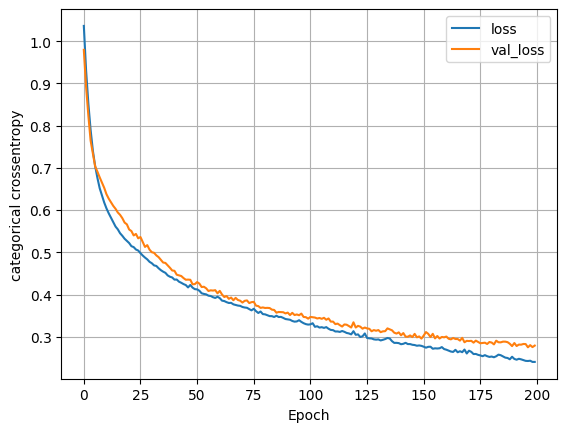

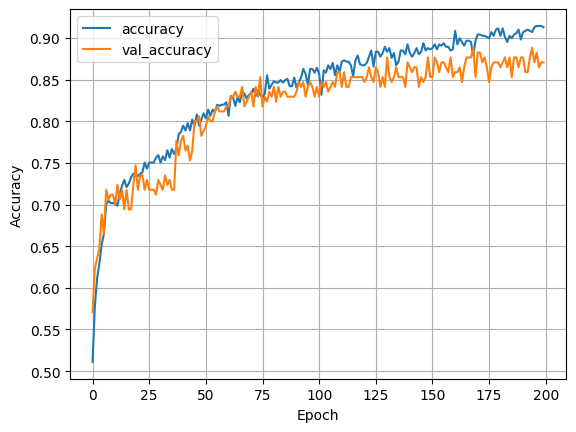

7/7 [==============================] - 0s 2ms/step - loss: 0.3986 - accuracy: 0.8255


In [209]:
plot_loss(history)
plot_accuracy(history)
loss, accuracy = nn_model.evaluate(X_test_normal, y_test)

7/7 [==============================] - 0s 3ms/step - loss: 0.5289 - accuracy: 0.7311
num_nodes: 16, lr: 0.1, batch_size: 32


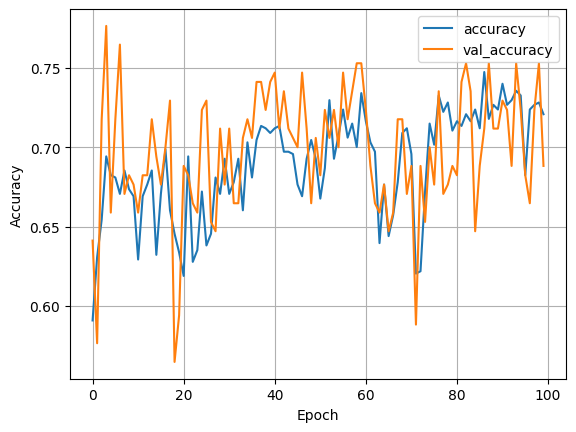

7/7 [==============================] - 0s 2ms/step - loss: 0.6499 - accuracy: 0.7736
num_nodes: 16, lr: 0.1, batch_size: 64


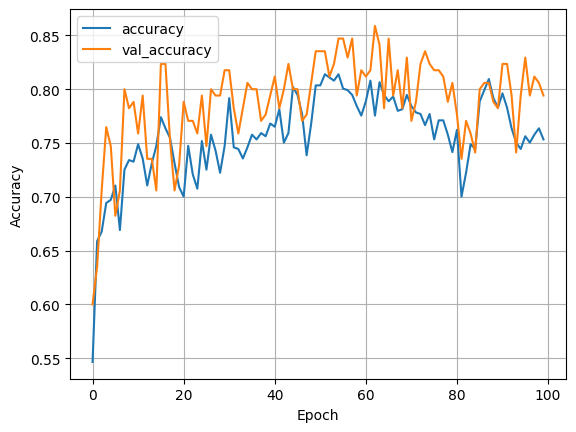

7/7 [==============================] - 0s 2ms/step - loss: 0.5781 - accuracy: 0.7594
num_nodes: 16, lr: 0.1, batch_size: 128


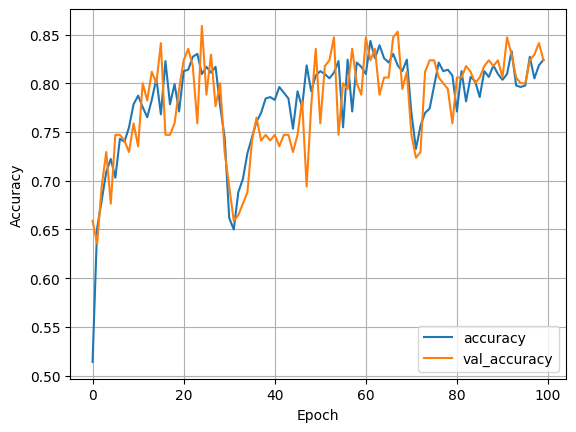

7/7 [==============================] - 0s 2ms/step - loss: 0.5148 - accuracy: 0.8160
num_nodes: 16, lr: 0.01, batch_size: 32


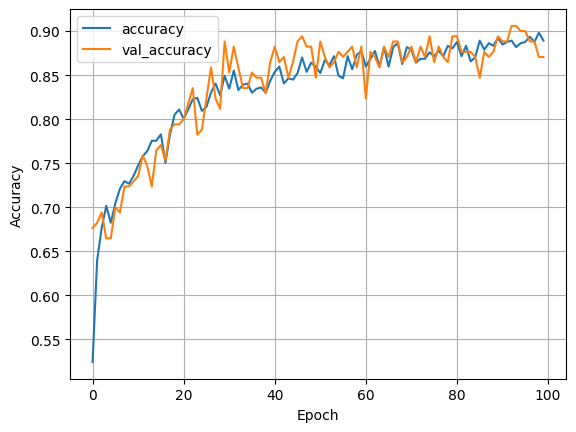

7/7 [==============================] - 0s 2ms/step - loss: 0.4079 - accuracy: 0.8538
num_nodes: 16, lr: 0.01, batch_size: 64


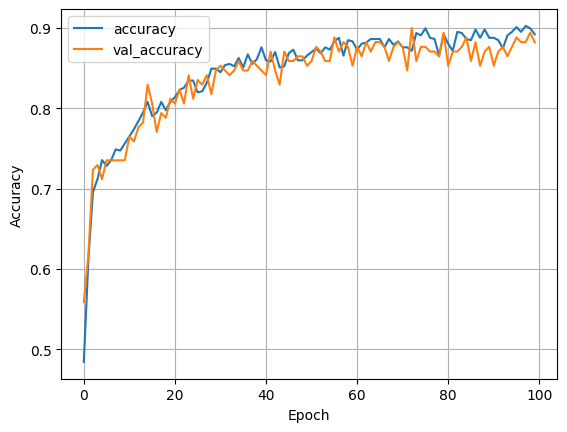

7/7 [==============================] - 0s 2ms/step - loss: 0.4318 - accuracy: 0.8491
num_nodes: 16, lr: 0.01, batch_size: 128


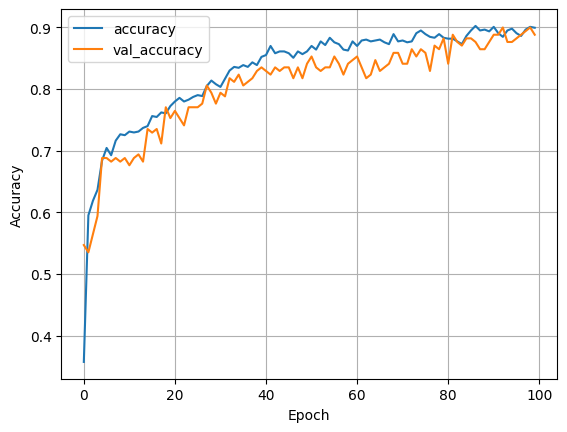

7/7 [==============================] - 0s 2ms/step - loss: 0.4985 - accuracy: 0.7311
num_nodes: 16, lr: 0.001, batch_size: 32


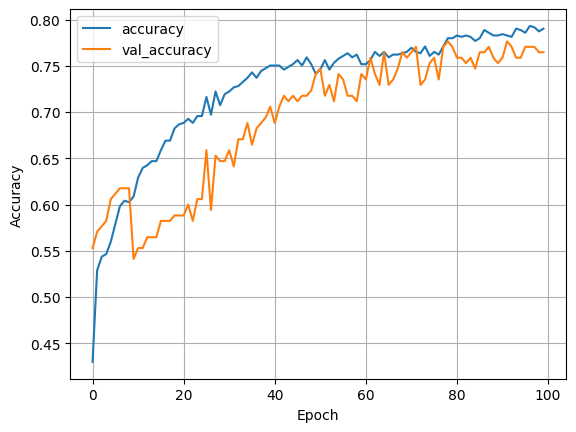

7/7 [==============================] - 0s 2ms/step - loss: 0.5288 - accuracy: 0.7500
num_nodes: 16, lr: 0.001, batch_size: 64


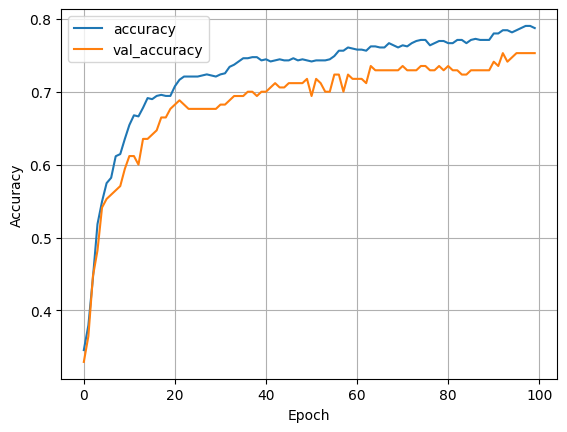

7/7 [==============================] - 0s 3ms/step - loss: 0.5374 - accuracy: 0.7217
num_nodes: 16, lr: 0.001, batch_size: 128


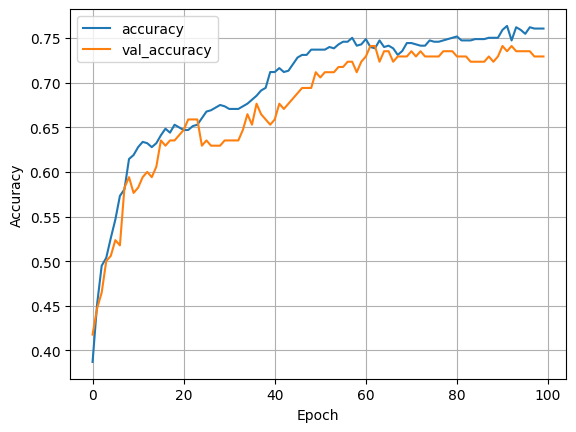

7/7 [==============================] - 0s 4ms/step - loss: 0.7959 - accuracy: 0.5755
num_nodes: 32, lr: 0.1, batch_size: 32


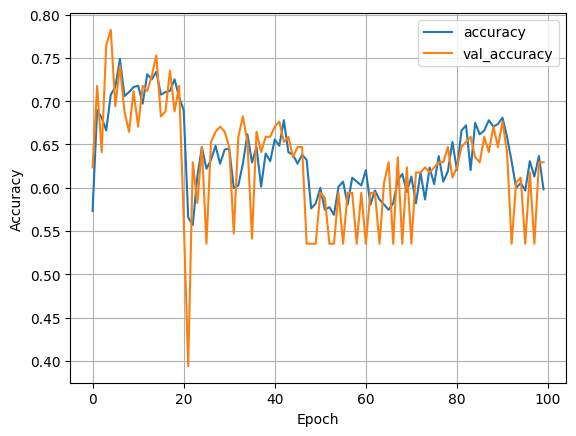

7/7 [==============================] - 0s 2ms/step - loss: 0.7148 - accuracy: 0.5755
num_nodes: 32, lr: 0.1, batch_size: 64


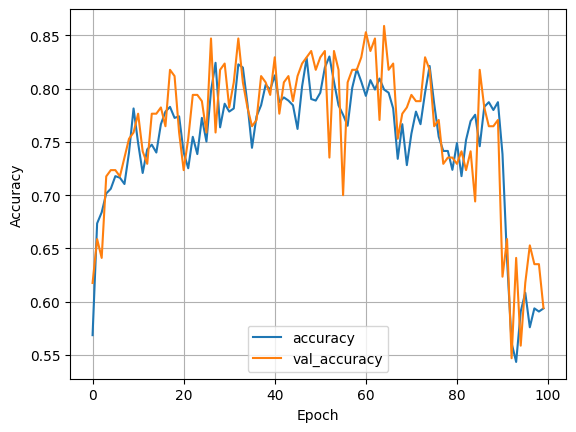

7/7 [==============================] - 0s 2ms/step - loss: 0.6512 - accuracy: 0.7123
num_nodes: 32, lr: 0.1, batch_size: 128


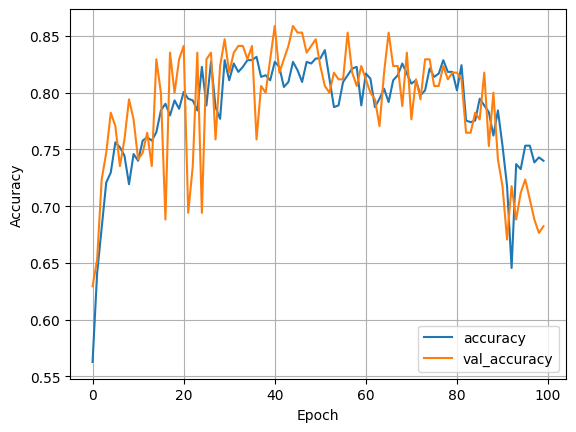

7/7 [==============================] - 0s 2ms/step - loss: 0.4330 - accuracy: 0.8868
num_nodes: 32, lr: 0.01, batch_size: 32


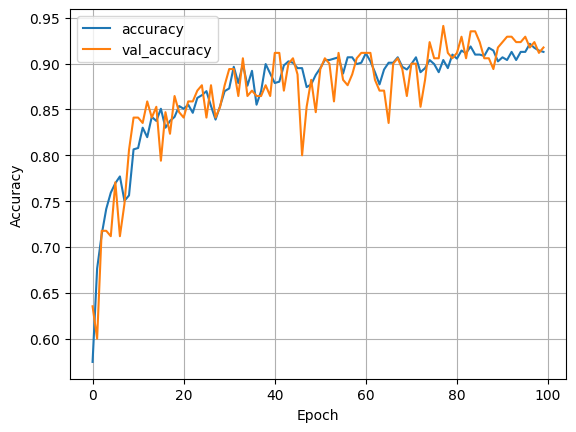

7/7 [==============================] - 0s 3ms/step - loss: 0.3644 - accuracy: 0.8915
num_nodes: 32, lr: 0.01, batch_size: 64


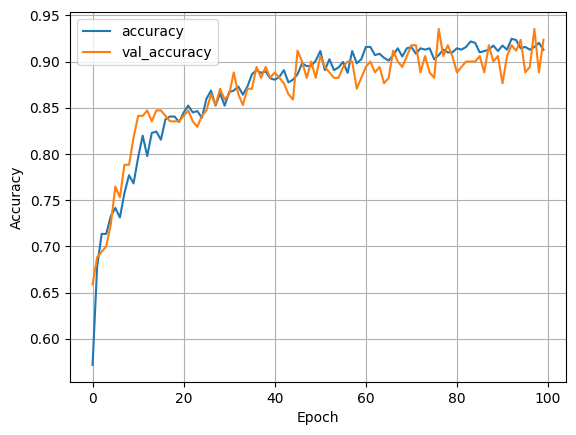

7/7 [==============================] - 0s 2ms/step - loss: 0.4206 - accuracy: 0.8632
num_nodes: 32, lr: 0.01, batch_size: 128


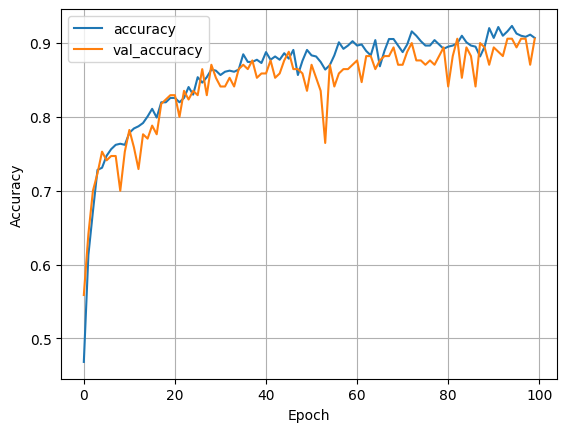

7/7 [==============================] - 0s 3ms/step - loss: 0.4125 - accuracy: 0.8160
num_nodes: 32, lr: 0.001, batch_size: 32


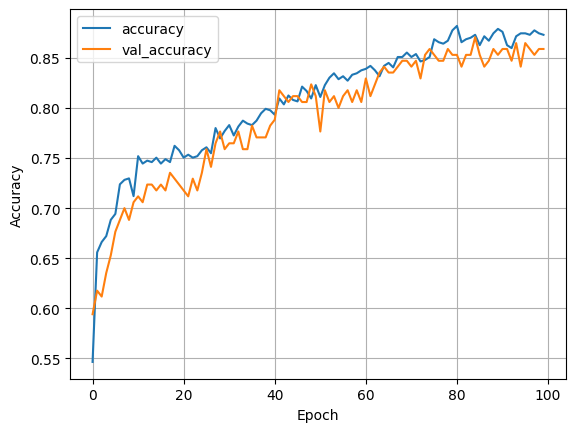

7/7 [==============================] - 0s 2ms/step - loss: 0.4762 - accuracy: 0.7594
num_nodes: 32, lr: 0.001, batch_size: 64


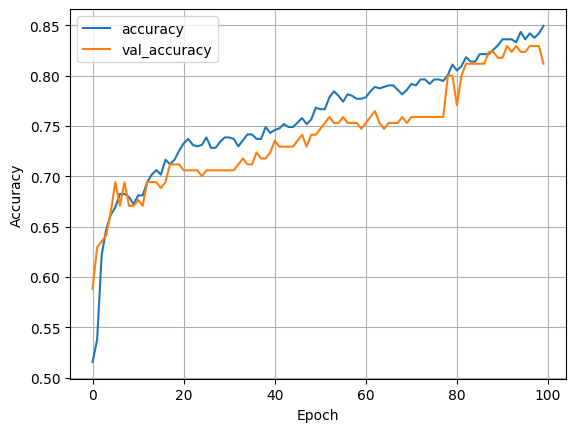

7/7 [==============================] - 0s 2ms/step - loss: 0.4764 - accuracy: 0.7594
num_nodes: 32, lr: 0.001, batch_size: 128


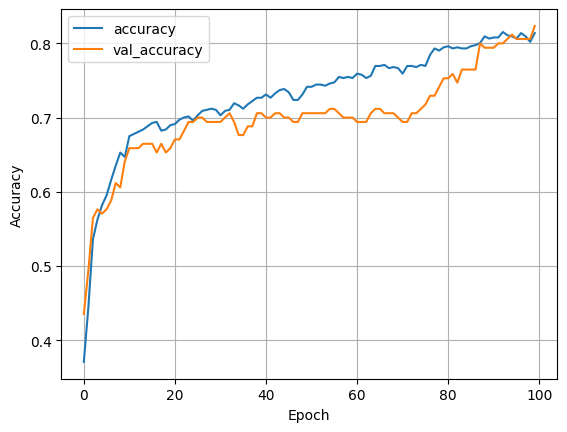

7/7 [==============================] - 0s 3ms/step - loss: 0.6316 - accuracy: 0.6179
num_nodes: 64, lr: 0.1, batch_size: 32


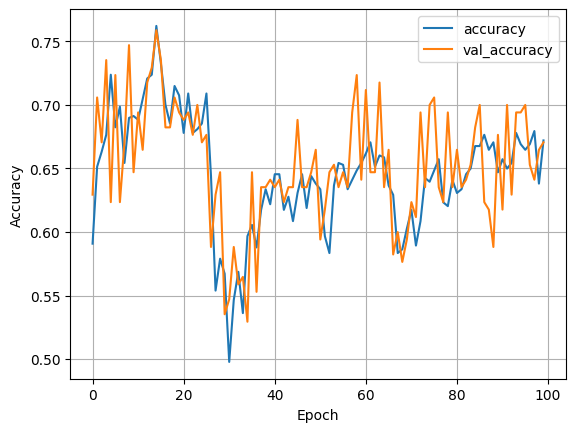

7/7 [==============================] - 0s 3ms/step - loss: 0.6114 - accuracy: 0.6604
num_nodes: 64, lr: 0.1, batch_size: 64


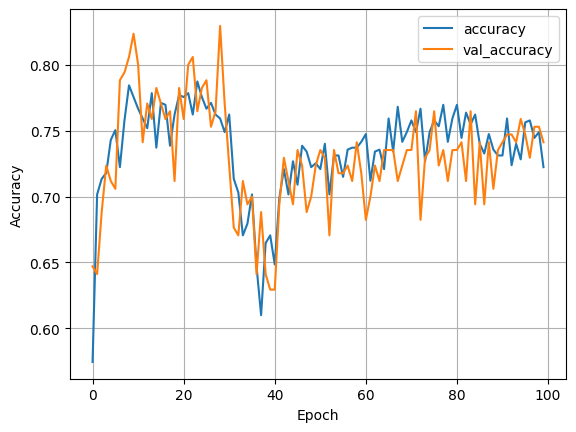

7/7 [==============================] - 0s 2ms/step - loss: 0.5929 - accuracy: 0.7406
num_nodes: 64, lr: 0.1, batch_size: 128


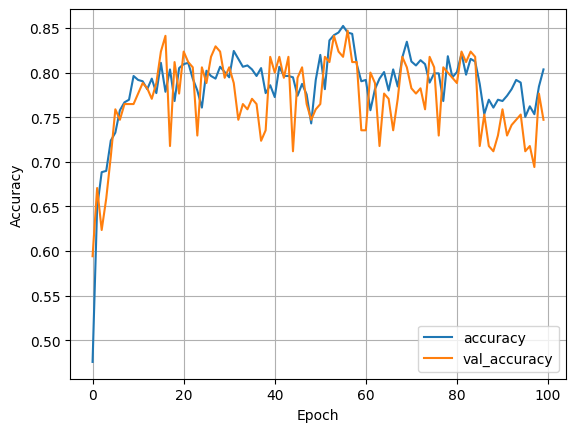

7/7 [==============================] - 0s 2ms/step - loss: 0.3610 - accuracy: 0.8868
num_nodes: 64, lr: 0.01, batch_size: 32


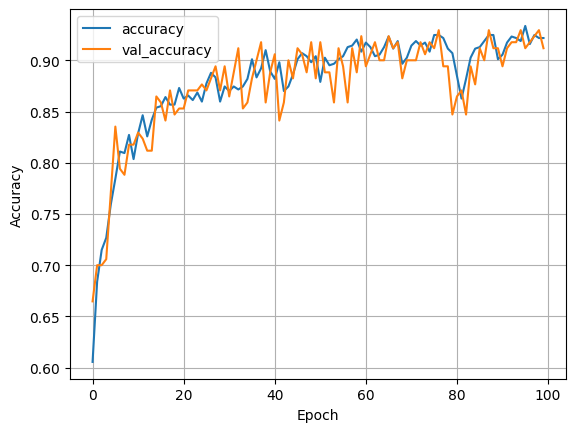

7/7 [==============================] - 0s 4ms/step - loss: 0.3541 - accuracy: 0.9057
num_nodes: 64, lr: 0.01, batch_size: 64


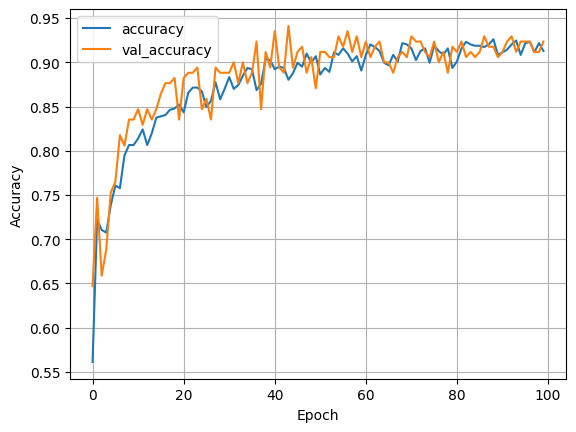

7/7 [==============================] - 0s 3ms/step - loss: 0.3518 - accuracy: 0.8774
num_nodes: 64, lr: 0.01, batch_size: 128


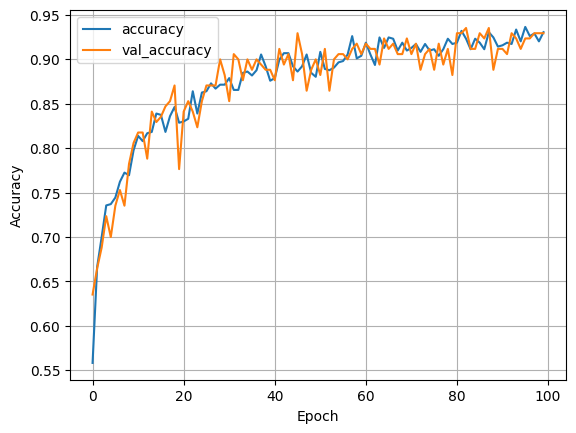

7/7 [==============================] - 0s 2ms/step - loss: 0.3876 - accuracy: 0.8349
num_nodes: 64, lr: 0.001, batch_size: 32


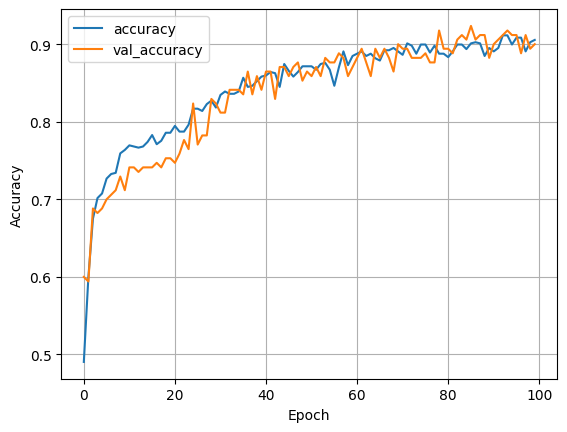

7/7 [==============================] - 0s 3ms/step - loss: 0.4010 - accuracy: 0.8302
num_nodes: 64, lr: 0.001, batch_size: 64


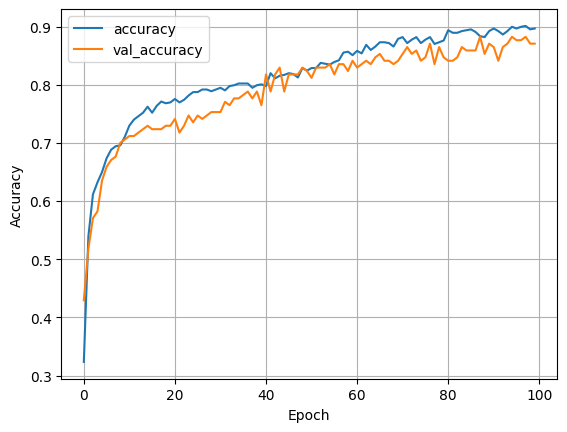

7/7 [==============================] - 0s 2ms/step - loss: 0.4441 - accuracy: 0.7972
num_nodes: 64, lr: 0.001, batch_size: 128


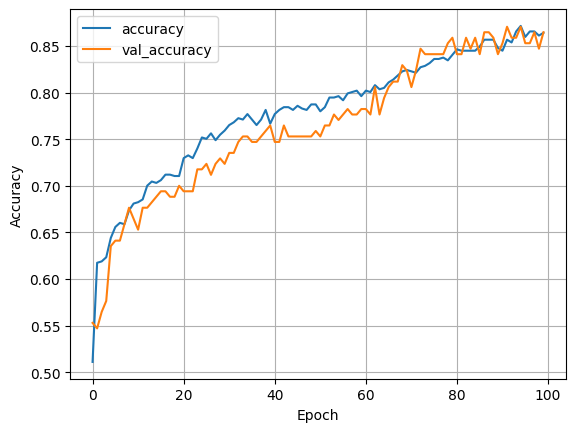

In [210]:
max_accuracy=0
best_model=None
for num_nodes in [16,32,64]:
  for lr in [0.1,0.01,0.001]:
    for batch_size in [32,64,128]:
      nn_model, history = train_model(X_train,y_train,num_nodes,lr,batch_size,100)
      loss, accuracy = nn_model.evaluate(X_test_normal, y_test)
      if accuracy>max_accuracy:
        max_accuracy=accuracy
        best_model=nn_model
      print(f"num_nodes: {num_nodes}, lr: {lr}, batch_size: {batch_size}")
      plot_accuracy(history)


In [211]:
accuracy=best_model.evaluate(X_test_normal, y_test)[1]
comp_df.loc[len(comp_df)]=0
comp_df.loc[len(comp_df)-1,"Name"]="Neural Network"
comp_df.loc[len(comp_df)-1,"accuracy"]=accuracy
comp_df.sort_values(by="accuracy",ascending=False,inplace=True)
comp_df.reset_index(drop=True,inplace=True)
comp_df


7/7 [==============================] - 0s 2ms/step - loss: 0.3541 - accuracy: 0.9057


Name  accuracy precision                                \
                                           0         1         2 macro avg   
0         Random Forest   0.933962  0.910448  0.916667  0.972603  0.933239   
1          Decision Tree  0.929245  0.897059  0.902778  0.986111  0.928649   
2       Decision Tree gs  0.929245  0.897059  0.890411  1.000000  0.929157   
3       Random Forest gs  0.919811  0.882353  0.888889  0.986111  0.919118   
4   Gradient Boosting gs  0.910377  0.878788  0.853333  1.000000  0.910707   
5         Neural Network  0.905660  0.000000  0.000000  0.000000  0.000000   
6                 KNN gs  0.882075  0.843750  0.815789  0.986111  0.881884   
7      Gradient Boosting  0.877358  0.830769  0.813333  0.986111  0.876738   
8                 SVM gs  0.872642  0.791667  0.835616  1.000000  0.875761   
9                    KNN  0.844340  0.794118  0.763158  0.985294  0.847523   
10                   SVM  0.773585  0.635294  0.757143  1.000000  0.797479   
11                 Bayes  0.632075  0.584906  0.580247  0.717949  0.627700   
12              Bayes gs  0.627358  0.600000  0.566265  0.708861  0.625042   

                   recall                                             \
   weighted avg         0         1         2 macro avg weighted avg   
0      0.933376  0.884058  0.916667  1.000000  0.933575     0.933962   
1      0.928825  0.884058  0.902778  1.000000  0.928945     0.929245   
2      0.929277  0.884058  0.902778  1.000000  0.928945     0.929245   
3      0.919322  0.869565  0.888889  1.000000  0.919485     0.919811   
4      0.910738  0.840580  0.888889  1.000000  0.909823     0.910377   
5      0.000000  0.000000  0.000000  0.000000  0.000000     0.000000   
6      0.881932  0.782609  0.861111  1.000000  0.881240     0.882075   
7      0.876872  0.782609  0.847222  1.000000  0.876610     0.877358   
8      0.876365  0.826087  0.847222  0.943662  0.872324     0.872642   
9      0.847629  0.782609  0.805556  0.943662  0.843942     0.844340   
10     0.798819  0.782609  0.736111  0.802817  0.773846     0.773585   
11     0.627880  0.449275  0.652778  0.788732  0.630262     0.632075   
12     0.625001  0.434783  0.652778  0.788732  0.625431     0.627358   

          f1                                             
           0         1         2 macro avg weighted avg  
0   0.897059  0.916667  0.986111  0.933542     0.933279  
1   0.890511  0.902778  0.993007  0.929004     0.928765  
2   0.890511  0.896552  1.000000  0.929231     0.929021  
3   0.875912  0.888889  0.993007  0.919535     0.919269  
4   0.859259  0.870748  1.000000  0.910296     0.910003  
5   0.000000  0.000000  0.000000  0.000000     0.000000  
6   0.812030  0.837838  0.993007  0.881405     0.880958  
7   0.805970  0.829932  0.993007  0.876748     0.876303  
8   0.808511  0.841379  0.971014  0.874097     0.873635  
9   0.788321  0.783784  0.964029  0.845626     0.845378  
10  0.701299  0.746479  0.890625  0.780049     0.779468  
11  0.508197  0.614379  0.751678  0.625802     0.624751  
12  0.504202  0.606452  0.746667  0.620131     0.619107

#Analysis


The best peforming algorithim for our problem was Random Forest algorithm. Most of the other algoritmhs also performed great, with accuracy around 0.9. Only algorithm that didn't produce acceptable results was Naive Bayes Classificator. The reason why that happened probably is that we used Gaussian Naive Bayes Classificator, that requires data to be normally distirubted, and it wasn't the case in our problem. Other types of Naive Bayes Classificators also didn't produce better results.

In [212]:
comp_df.sort_values(by=('precision','weighted avg'),ascending=False)

Name  accuracy precision                                \
                                           0         1         2 macro avg   
0         Random Forest   0.933962  0.910448  0.916667  0.972603  0.933239   
2       Decision Tree gs  0.929245  0.897059  0.890411  1.000000  0.929157   
1          Decision Tree  0.929245  0.897059  0.902778  0.986111  0.928649   
3       Random Forest gs  0.919811  0.882353  0.888889  0.986111  0.919118   
4   Gradient Boosting gs  0.910377  0.878788  0.853333  1.000000  0.910707   
6                 KNN gs  0.882075  0.843750  0.815789  0.986111  0.881884   
7      Gradient Boosting  0.877358  0.830769  0.813333  0.986111  0.876738   
8                 SVM gs  0.872642  0.791667  0.835616  1.000000  0.875761   
9                    KNN  0.844340  0.794118  0.763158  0.985294  0.847523   
10                   SVM  0.773585  0.635294  0.757143  1.000000  0.797479   
11                 Bayes  0.632075  0.584906  0.580247  0.717949  0.627700   
12              Bayes gs  0.627358  0.600000  0.566265  0.708861  0.625042   
5         Neural Network  0.905660  0.000000  0.000000  0.000000  0.000000   

                   recall                                             \
   weighted avg         0         1         2 macro avg weighted avg   
0      0.933376  0.884058  0.916667  1.000000  0.933575     0.933962   
2      0.929277  0.884058  0.902778  1.000000  0.928945     0.929245   
1      0.928825  0.884058  0.902778  1.000000  0.928945     0.929245   
3      0.919322  0.869565  0.888889  1.000000  0.919485     0.919811   
4      0.910738  0.840580  0.888889  1.000000  0.909823     0.910377   
6      0.881932  0.782609  0.861111  1.000000  0.881240     0.882075   
7      0.876872  0.782609  0.847222  1.000000  0.876610     0.877358   
8      0.876365  0.826087  0.847222  0.943662  0.872324     0.872642   
9      0.847629  0.782609  0.805556  0.943662  0.843942     0.844340   
10     0.798819  0.782609  0.736111  0.802817  0.773846     0.773585   
11     0.627880  0.449275  0.652778  0.788732  0.630262     0.632075   
12     0.625001  0.434783  0.652778  0.788732  0.625431     0.627358   
5      0.000000  0.000000  0.000000  0.000000  0.000000     0.000000   

          f1                                             
           0         1         2 macro avg weighted avg  
0   0.897059  0.916667  0.986111  0.933542     0.933279  
2   0.890511  0.896552  1.000000  0.929231     0.929021  
1   0.890511  0.902778  0.993007  0.929004     0.928765  
3   0.875912  0.888889  0.993007  0.919535     0.919269  
4   0.859259  0.870748  1.000000  0.910296     0.910003  
6   0.812030  0.837838  0.993007  0.881405     0.880958  
7   0.805970  0.829932  0.993007  0.876748     0.876303  
8   0.808511  0.841379  0.971014  0.874097     0.873635  
9   0.788321  0.783784  0.964029  0.845626     0.845378  
10  0.701299  0.746479  0.890625  0.780049     0.779468  
11  0.508197  0.614379  0.751678  0.625802     0.624751  
12  0.504202  0.606452  0.746667  0.620131     0.619107  
5   0.000000  0.000000  0.000000  0.000000     0.000000

When we look at the most precise algorithms the results are very similar to the results sorted by accuracy.

In [214]:
#comp_df[["Name",("precision","0")]]
print(comp_df.drop(index=6)[[("precision","0"),("f1","0"),("recall","0")]],"\n\n")
print(comp_df.drop(index=6)[[("precision","1"),("f1","1"),("recall","1")]],"\n\n")
print(comp_df.drop(index=6)[[("precision","2"),("f1","2"),("recall","2")]])

   precision        f1    recall
           0         0         0
0   0.910448  0.897059  0.884058
1   0.897059  0.890511  0.884058
2   0.897059  0.890511  0.884058
3   0.882353  0.875912  0.869565
4   0.878788  0.859259  0.840580
5   0.000000  0.000000  0.000000
7   0.830769  0.805970  0.782609
8   0.791667  0.808511  0.826087
9   0.794118  0.788321  0.782609
10  0.635294  0.701299  0.782609
11  0.584906  0.508197  0.449275
12  0.600000  0.504202  0.434783 


   precision        f1    recall
           1         1         1
0   0.916667  0.916667  0.916667
1   0.902778  0.902778  0.902778
2   0.890411  0.896552  0.902778
3   0.888889  0.888889  0.888889
4   0.853333  0.870748  0.888889
5   0.000000  0.000000  0.000000
7   0.813333  0.829932  0.847222
8   0.835616  0.841379  0.847222
9   0.763158  0.783784  0.805556
10  0.757143  0.746479  0.736111
11  0.580247  0.614379  0.652778
12  0.566265  0.606452  0.652778 


   precision        f1    recall
           2         2         2
0   

As we can see in the table above, the algorithms worked great for classifying data from second class, which is "high risk". They correctly predicted albost 100% of the cases, which is very impressive.